## Load required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

## Load in data

In [2]:
#Loading the dataset
birds = pd.read_csv("/content/Angry+Birds+(Cardinal+Personalities).xlsx.csv")

In [3]:
# Inspect first 5 rows
birds.head()

,Month,Habitat,Site,Location,Sex,SexID,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness,Personality
0,Feb,Rural,Ocala,Farm,M,2,35,9.1,21.76,5.23,5.86,6.25,0.87026,1.85823,0.83398,0.43279,-1.35431,Angry Bird
1,Sept,Urban,GNV,GNV,F,1,37,8.4,20.09,3.05,5.08,7.26,1.46306,-0.60086,-0.92405,0.72763,1.08221,Angry Bird
2,Feb,Urban,Ocala,Ocala,F,1,37,8.6,19.50,8.73,10.48,19.49,1.94799,-0.05401,0.24467,-1.89158,-0.18457,A Pretty Chill Bird
3,Dec,Rural,GNV,ACF,F,1,37,8.4,19.36,11.11,23.60,24.87,0.06201,-0.54020,0.17969,0.04281,1.08080,Standard Bird
4,Nov,Urban,GNV,GNV,F,1,38,8.4,19.01,1.33,1.39,39.82,-0.96196,0.30524,-0.45602,-0.23742,0.56366,A Pretty Chill Bird


In [4]:
# Inspect last 5 rows
birds.tail()

,Month,Habitat,Site,Location,Sex,SexID,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness,Personality
62,Oct,Urban,GNV,GNV,M,2,45,8.6,20.29,0.50,2.61,5.50,-0.90804,-0.53611,-1.30760,0.43248,-0.71326,A Pretty Chill Bird
63,Oct,Rural,GNV,ACF,F,1,45,9.0,20.87,7.67,10.02,19.82,-0.20749,1.87524,1.29706,0.54875,-0.39362,Standard Bird
64,Dec,Urban,Ocala,Ocala,M,2,46,9.1,21.23,1.46,2.32,9.43,0.38521,1.39855,-1.21477,0.47695,-1.49095,Standard Bird
65,Feb,Urban,Ocala,Ocala,M,2,46,8.9,21.33,4.65,8.50,18.09,-0.26138,0.06525,-0.15292,-1.89158,-0.90095,A Pretty Chill Bird
66,Jan,Rural,Ocala,Farm,M,2,48,9.2,21.81,0.54,1.38,21.67,1.62467,-0.51944,-1.31487,0.61705,-0.51363,A Pretty Chill Bird


In [5]:
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        67 non-null     object 
 1   Habitat      67 non-null     object 
 2   Site         67 non-null     object 
 3   Location     67 non-null     object 
 4   Sex          67 non-null     object 
 5   SexID        67 non-null     int64  
 6   Weight       67 non-null     int64  
 7   WingL        67 non-null     float64
 8   TarsusL      67 non-null     float64
 9   CORT1        67 non-null     float64
 10  CORT2        67 non-null     float64
 11  CORT3        67 non-null     float64
 12  Exploration  67 non-null     float64
 13  Neophobia    67 non-null     float64
 14  Neophilia    67 non-null     float64
 15  Aggression   67 non-null     float64
 16  Boldness     67 non-null     float64
 17  Personality  67 non-null     object 
dtypes: float64(10), int64(2), object(6)
memory usage: 9.

There are no missing values in the dataset

### Data preprocessing

In [6]:
# Drop redundant or not so useful columns for model building
birds = birds.drop(['Site','SexID'],axis=1)


# We take a copy of our source data.
df = copy.deepcopy(birds)
df_personality= copy.deepcopy(birds)
df.head()

,Month,Habitat,Location,Sex,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness,Personality
0,Feb,Rural,Farm,M,35,9.1,21.76,5.23,5.86,6.25,0.87026,1.85823,0.83398,0.43279,-1.35431,Angry Bird
1,Sept,Urban,GNV,F,37,8.4,20.09,3.05,5.08,7.26,1.46306,-0.60086,-0.92405,0.72763,1.08221,Angry Bird
2,Feb,Urban,Ocala,F,37,8.6,19.50,8.73,10.48,19.49,1.94799,-0.05401,0.24467,-1.89158,-0.18457,A Pretty Chill Bird
3,Dec,Rural,ACF,F,37,8.4,19.36,11.11,23.60,24.87,0.06201,-0.54020,0.17969,0.04281,1.08080,Standard Bird
4,Nov,Urban,GNV,F,38,8.4,19.01,1.33,1.39,39.82,-0.96196,0.30524,-0.45602,-0.23742,0.56366,A Pretty Chill Bird


## K-means Clustering

In [7]:
# Remove species column for clustering
df = df.drop('Personality', axis=1)

In [8]:
# Define month mapping
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Apply month mapping to the 'Month' column
df['Month'] = df['Month'].map(month_mapping)

In [9]:
# Convert categorical variables to numeric
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature]).codes # Replace strings with an integer

In [10]:
df.head()

,Month,Habitat,Location,Sex,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness
0,2,0,1,1,35,9.1,21.76,5.23,5.86,6.25,0.87026,1.85823,0.83398,0.43279,-1.35431
1,9,1,2,0,37,8.4,20.09,3.05,5.08,7.26,1.46306,-0.60086,-0.92405,0.72763,1.08221
2,2,1,3,0,37,8.6,19.50,8.73,10.48,19.49,1.94799,-0.05401,0.24467,-1.89158,-0.18457
3,12,0,0,0,37,8.4,19.36,11.11,23.60,24.87,0.06201,-0.54020,0.17969,0.04281,1.08080
4,11,1,2,0,38,8.4,19.01,1.33,1.39,39.82,-0.96196,0.30524,-0.45602,-0.23742,0.56366


In [11]:
# Perform K-means clustering
# Define the model
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit and predict
df_personality['Kcluster'] = kmeans.fit_predict(df)

In [12]:
df_personality.head(10)

,Month,Habitat,Location,Sex,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness,Personality,Kcluster
0,Feb,Rural,Farm,M,35,9.1,21.76,5.23,5.86,6.25,0.87026,1.85823,0.83398,0.43279,-1.35431,Angry Bird,0
1,Sept,Urban,GNV,F,37,8.4,20.09,3.05,5.08,7.26,1.46306,-0.60086,-0.92405,0.72763,1.08221,Angry Bird,0
2,Feb,Urban,Ocala,F,37,8.6,19.50,8.73,10.48,19.49,1.94799,-0.05401,0.24467,-1.89158,-0.18457,A Pretty Chill Bird,2
3,Dec,Rural,ACF,F,37,8.4,19.36,11.11,23.60,24.87,0.06201,-0.54020,0.17969,0.04281,1.08080,Standard Bird,1
4,Nov,Urban,GNV,F,38,8.4,19.01,1.33,1.39,39.82,-0.96196,0.30524,-0.45602,-0.23742,0.56366,A Pretty Chill Bird,1
5,Sept,Urban,GNV,F,38,8.1,21.65,0.14,2.88,6.86,0.38525,-0.53171,-0.63305,0.11234,-1.01015,A Pretty Chill Bird,0
6,Oct,Urban,GNV,F,38,8.6,19.75,3.29,4.33,5.24,-1.01584,-0.40591,0.32876,-0.79294,-0.97150,A Pretty Chill Bird,0
7,Nov,Rural,ACF,F,38,8.0,20.14,4.38,5.65,7.53,-0.58471,-0.53110,0.49654,-1.89158,0.71855,A Pretty Chill Bird,0
8,Sept,Urban,GNV,F,38,8.5,22.19,1.97,5.81,6.33,-1.17750,0.09876,-0.99330,-1.30205,0.84473,Standard Bird,0
9,Feb,Rural,Farm,M,38,8.7,19.30,6.81,7.38,17.90,0.11584,-0.53465,-0.79683,-0.32675,0.89031,Standard Bird,2


In [13]:
df_personality.tail(10)

,Month,Habitat,Location,Sex,Weight,WingL,TarsusL,CORT1,CORT2,CORT3,Exploration,Neophobia,Neophilia,Aggression,Boldness,Personality,Kcluster
57,Jan,Rural,Farm,M,44,9.1,19.73,2.65,5.47,6.08,-0.15357,-0.54020,1.60219,1.46329,-0.60479,Standard Bird,0
58,Feb,Urban,Ocala,M,44,9.1,19.53,1.02,11.11,15.61,1.78630,-0.36733,-1.01838,0.04605,-1.53973,Angry Bird,2
59,Nov,Urban,GNV,F,44,8.6,20.62,1.04,12.05,22.28,-0.74636,-0.58846,-0.72205,0.29991,1.08455,Standard Bird,2
60,Feb,Urban,Ocala,F,44,8.6,20.94,8.57,13.11,15.97,-0.69248,-0.52428,-0.17581,0.63112,-1.29251,Angry Bird,2
61,Oct,Urban,GNV,F,45,8.7,19.43,0.32,1.39,13.35,-0.09977,-0.51961,-1.66934,0.48787,1.07986,A Pretty Chill Bird,0
62,Oct,Urban,GNV,M,45,8.6,20.29,0.50,2.61,5.50,-0.90804,-0.53611,-1.30760,0.43248,-0.71326,A Pretty Chill Bird,0
63,Oct,Rural,ACF,F,45,9.0,20.87,7.67,10.02,19.82,-0.20749,1.87524,1.29706,0.54875,-0.39362,Standard Bird,2
64,Dec,Urban,Ocala,M,46,9.1,21.23,1.46,2.32,9.43,0.38521,1.39855,-1.21477,0.47695,-1.49095,Standard Bird,0
65,Feb,Urban,Ocala,M,46,8.9,21.33,4.65,8.50,18.09,-0.26138,0.06525,-0.15292,-1.89158,-0.90095,A Pretty Chill Bird,2
66,Jan,Rural,Farm,M,48,9.2,21.81,0.54,1.38,21.67,1.62467,-0.51944,-1.31487,0.61705,-0.51363,A Pretty Chill Bird,2


## Visualization with matplotlib and seaborn


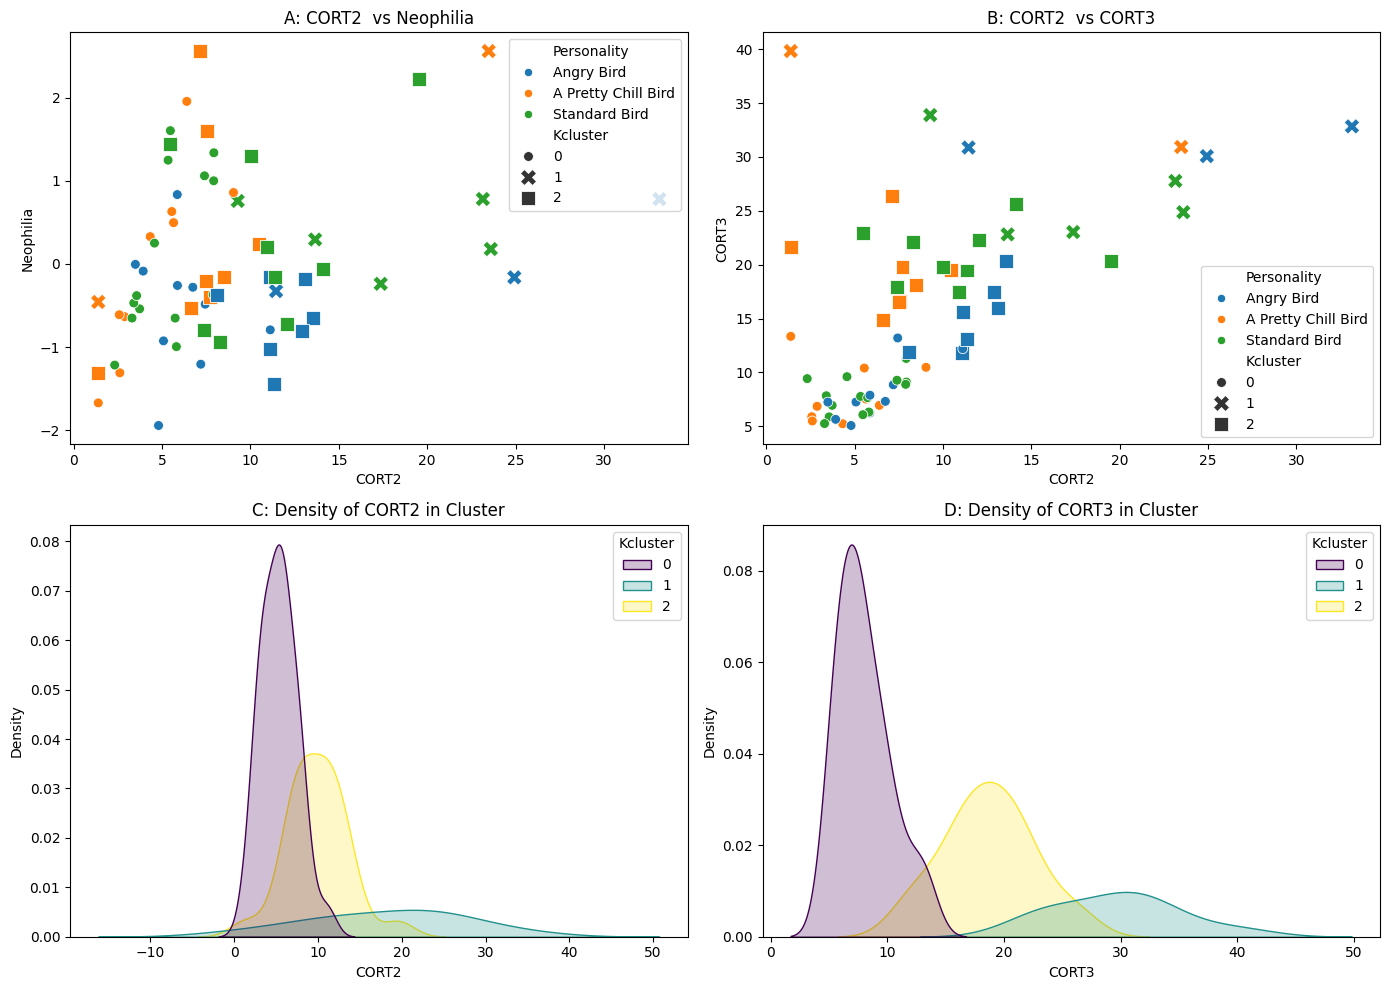

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1
sns.scatterplot(data=df_personality, y='Neophilia', x='CORT2', hue='Personality', style='Kcluster', size='Kcluster',sizes=(50,200), ax=axes[0, 0])
axes[0, 0].set_title('A: CORT2  vs Neophilia')

# Plot 2
sns.scatterplot(data=df_personality, x='CORT2', y='CORT3', hue='Personality', style='Kcluster', size='Kcluster',sizes=(50,200), ax=axes[0, 1])
axes[0, 1].set_title('B: CORT2  vs CORT3')

# Plot 3
sns.kdeplot(data=df_personality, x='CORT2', hue='Kcluster', fill=True, ax=axes[1, 0], palette ='viridis')
axes[1, 0].set_title('C: Density of CORT2 in Cluster')

# Plot 4
sns.kdeplot(data=df_personality, x='CORT3', hue='Kcluster', fill=True, ax=axes[1, 1], palette ='viridis')
axes[1, 1].set_title('D: Density of CORT3 in Cluster')

plt.tight_layout()
plt.show()

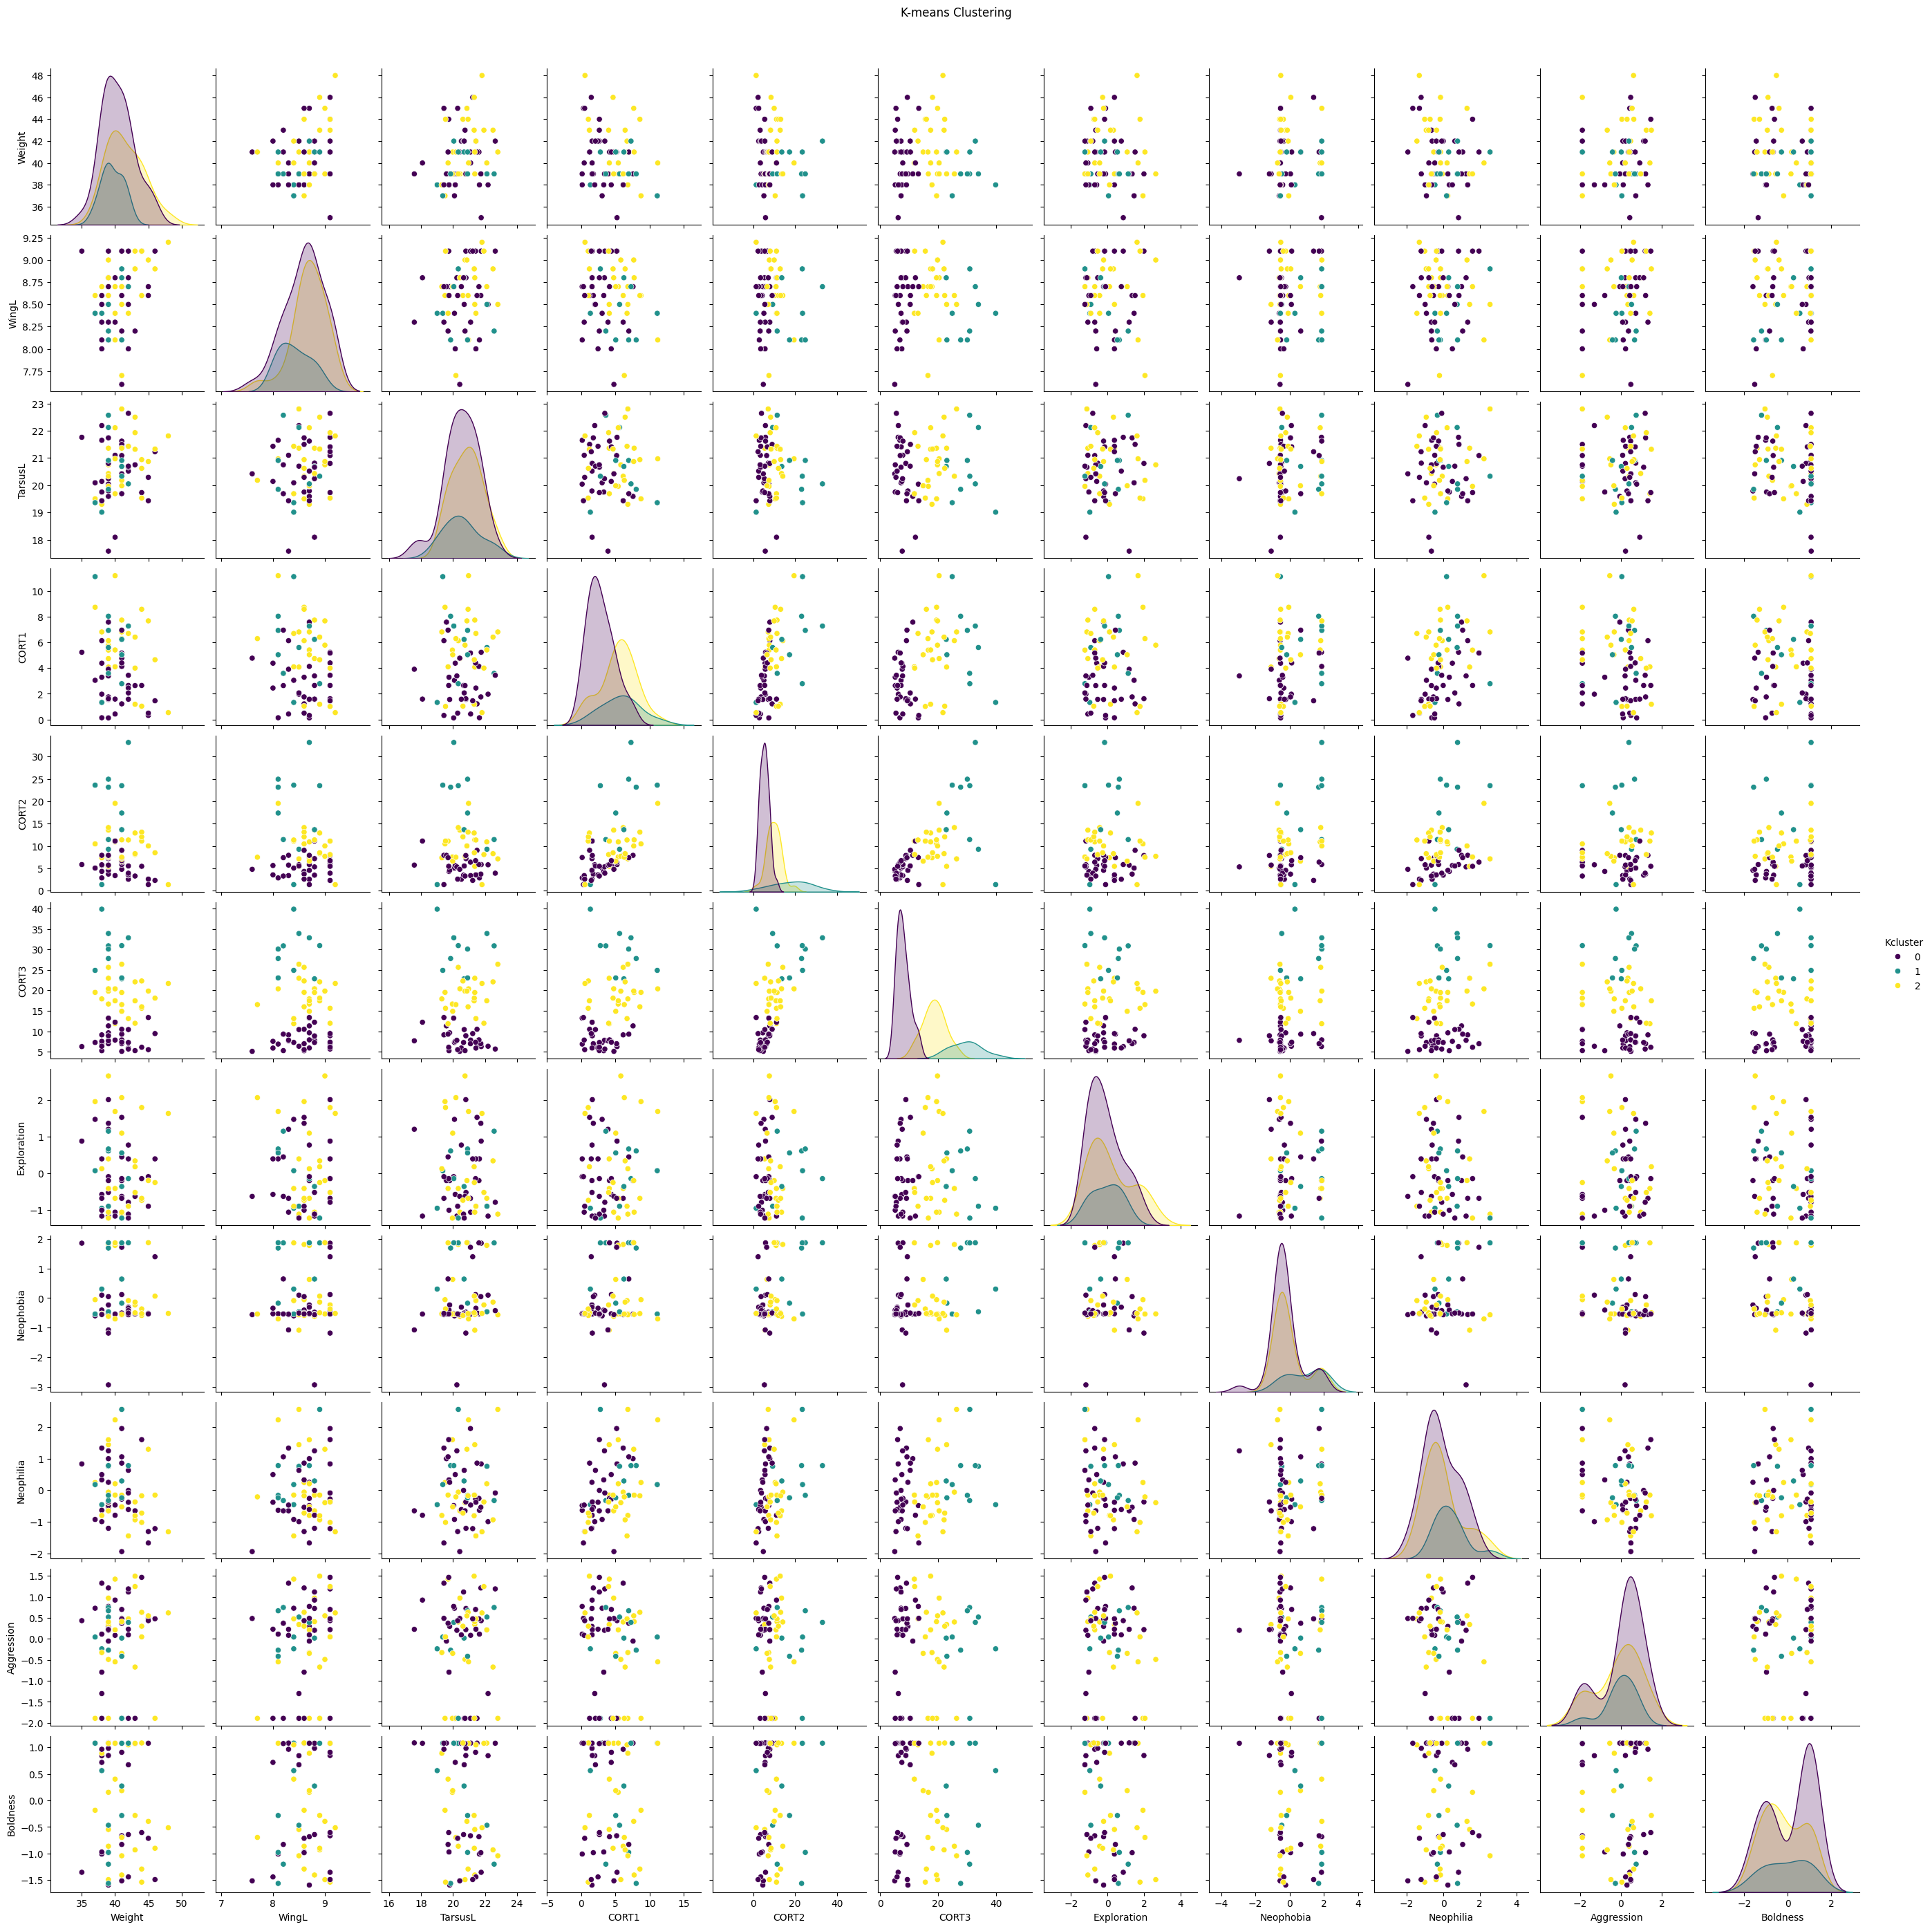

In [15]:
sns.pairplot(df_personality, hue='Kcluster', palette='viridis')
plt.suptitle('K-means Clustering', y=1.02)
plt.show()

## PCA Analysis

### Standardize the features to have `mean=0` and `variance=1`

In [16]:
scaler = StandardScaler()
birds_scaled = scaler.fit_transform(df)

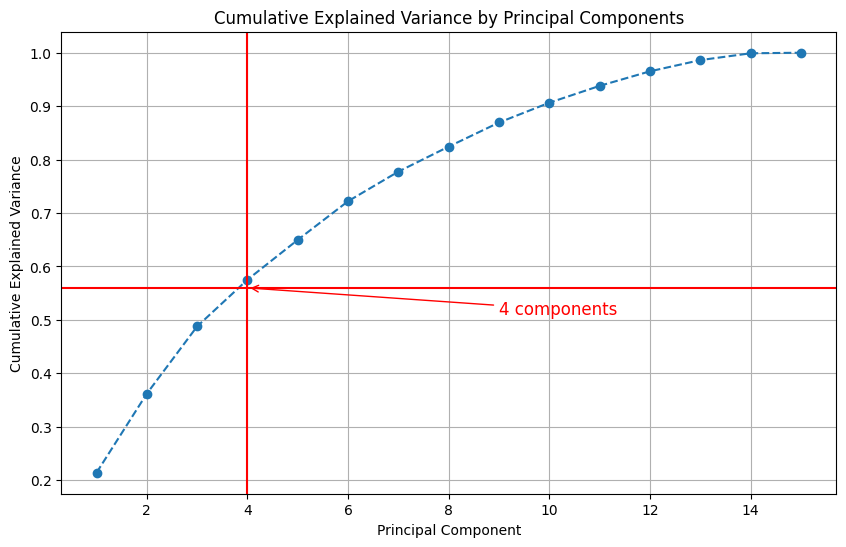

Number of components to retain 56% variance: 4


In [17]:
# Scale the data
scaled_data = birds_scaled

# Apply PCA
pca = PCA().fit(scaled_data)

# Get explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Decide number of components to retain 56% variance
threshold = 0.56
num_components = next(i for i, cumulative_var in enumerate(cumulative_explained_variance) if cumulative_var >= threshold) + 1

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.axvline(x=num_components, color='r', linestyle='-')
plt.annotate(f'{num_components} components', xy=(num_components, threshold), xytext=(num_components+5, threshold-0.05),
             arrowprops=dict(color='r', arrowstyle='->'),
             fontsize=12, color='r')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print(f"Number of components to retain 56% variance: {num_components}")



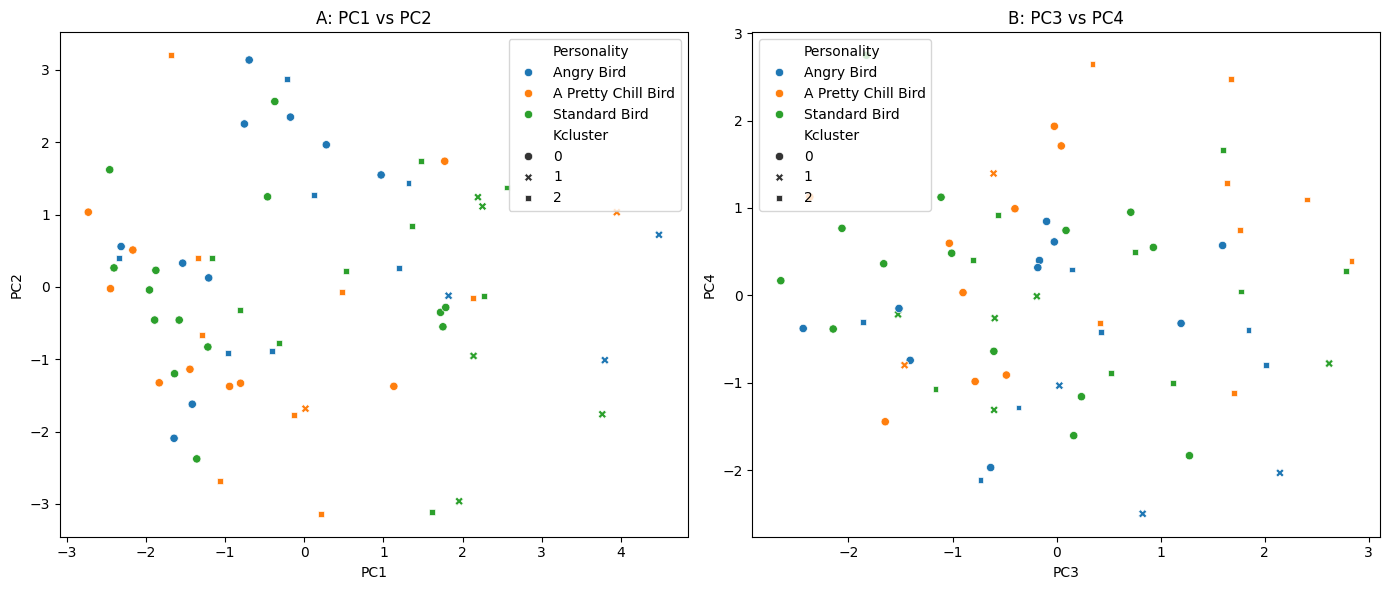

In [18]:
# Apply PCA with the chosen number of components
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(scaled_data)


# Add to DataFrame
PCA_output = pd.DataFrame(data = pca_result, columns = ['PC'+str(i) for i in range(1, 5)])
PCA_output['Kcluster'] = df_personality['Kcluster'].values
PCA_output['Personality'] = df_personality['Personality'].values

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=PCA_output, x='PC1', y='PC2', hue='Personality', style='Kcluster', ax=axes[0])
axes[0].set_title('A: PC1 vs PC2')

sns.scatterplot(data=PCA_output, x='PC3', y='PC4', hue='Personality', style='Kcluster', ax=axes[1])
axes[1].set_title('B: PC3 vs PC4')

plt.tight_layout()
plt.show()


In [19]:
PCA_output.head()

,PC1,PC2,PC3,PC4,Kcluster,Personality
0,0.971520,1.546653,1.595351,0.570913,0,Angry Bird
1,-1.414952,-1.621201,-1.407029,-0.744057,0,Angry Bird
2,0.210793,-3.135520,1.640043,1.286061,2,A Pretty Chill Bird
3,3.766207,-1.760452,-1.523932,-0.217419,1,Standard Bird
4,0.015511,-1.683120,-1.461037,-0.799000,1,A Pretty Chill Bird


## Interpretation of Results

### Standard deviation and variance of each principle component

In [20]:
# Standard deviation of each component
std_dev = np.sqrt(pca.explained_variance_)

# Variance of each component
variance = pca.explained_variance_

# Percentage of variance explained by each component
variance_ratio = pca.explained_variance_ratio_

# Convert to DataFrame for clearer visualization
df_pca = pd.DataFrame({'stdev': std_dev,
                       'variance': variance,
                       '% of variance': variance_ratio},
                       index=[f'PC{i+1}' for i in range(std_dev.shape[0])])

# Convert "Percentage of Variance" to a percentage
df_pca['% of variance'] = df_pca['% of variance'].map(lambda x: round(x*100, 2))

df_pca

,stdev,variance,% of variance
PC1,1.805694,3.260532,21.41
PC2,1.500873,2.252619,14.79
PC3,1.384499,1.916836,12.59
PC4,1.153613,1.330824,8.74


### Significance of each variable to the principal components

In [21]:
# Create a dataframe of the PCA components
df_components = pd.DataFrame(pca.components_, columns=df.columns)

# Transpose it, so that variables are the index and PCs are the columns
df_components = df_components.T

# Give the columns meaningful names
df_components.columns = [f'PC{i+1}' for i in range(df_components.shape[1])]

# Show the dataframe
df_components

,PC1,PC2,PC3,PC4
Month,0.107077,-0.085743,-0.478157,-0.293012
Habitat,-0.399288,-0.368258,0.085276,-0.005933
Location,-0.401507,-0.276135,0.307073,0.094402
Sex,-0.107104,0.446608,0.078511,0.223454
Weight,-0.158150,0.281348,0.179909,-0.182971
WingL,-0.068115,0.492334,0.134789,0.178811
TarsusL,0.002499,0.250780,0.331035,0.030458
CORT1,0.369636,-0.211264,0.223772,0.149910
CORT2,0.404442,-0.128189,0.120265,-0.132070
CORT3,0.345017,-0.083681,0.205620,-0.153266
